In [1]:
#import of packages 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

## 1.a

In [2]:
# import of 21in14ar.xls from line 7-27 and only 3 first columns
data_raw21 = pd.read_excel('21in14ar.xlsx', header=7, usecols=[0,1,2])

# renaming of columns
data_raw21.columns = ['Size of adjusted gross income', 'Number of returns', 'Adjusted gross income less deficit']

# dropping rows after 20th row no matter the value
data_raw21 = data_raw21.drop(data_raw21.index[20:])

# adjusting data type
data_raw21['Number of returns'] = data_raw21['Number of returns'].astype(int)
data_raw21['Adjusted gross income less deficit'] = data_raw21['Adjusted gross income less deficit'].astype(int)

# printing of data
display(data_raw21)

,Size of adjusted gross income,Number of returns,Adjusted gross income less deficit
0,"All returns, total",160824340,14795614070
1,No adjusted gross income,4098522,-171836364
2,"$1 under $5,000",8487025,19987243
3,"$5,000 under $10,000",8944908,67651359
4,"$10,000 under $15,000",10056377,125912056
5,"$15,000 under $20,000",9786580,170836129
6,"$20,000 under $25,000",8863570,199508960
7,"$25,000 under $30,000",8787576,241347179
8,"$30,000 under $40,000",16123068,561386434
9,"$40,000 under $50,000",12782334,573155378


In [3]:
def clean_data(raw,print_head=False):
    data = raw.copy()

    # transpose the data such that first row is made into a column added to the data
    all_returns = data.iloc[:2]

    # drop first column, subtracting returns with no AGI the and renaming columns
    all_returns = all_returns.drop(labels='Size of adjusted gross income', axis=1)
    all_returns = (all_returns.iloc[0]-all_returns.iloc[1])
    all_returns = all_returns.to_frame().T
    all_returns.columns = ['Total number of returns', 'Total adjusted gross income less deficit']

    # dropping first 2 rows with totals and no AGI
    data = data.drop(data.index[:2])

    # adding a 0 row to the data as the first row and resetting the index
    data = pd.concat([pd.DataFrame({'Size of adjusted gross income': ['0'], 'Number of returns': [0], 'Adjusted gross income less deficit': [0]}), data], ignore_index=True)
    data = data.reset_index(drop=True)

    # joining the data
    data = data.join(all_returns, how='cross')

    # calculating the percentage of total returns
    data['Percentage of total returns'] = data['Number of returns'] / data['Total number of returns']
    data['Percentage of total AGI'] = data['Adjusted gross income less deficit'] / data['Total adjusted gross income less deficit']

    data['Cumsum percentage of total returns'] = np.cumsum(data['Percentage of total returns'])
    data['Cumsum percentage of total AGI'] = np.cumsum(data['Percentage of total AGI'])

    if print_head:
        display(data.head())

    return data

data21 = clean_data(data_raw21, print_head=True)

,Size of adjusted gross income,Number of returns,Adjusted gross income less deficit,Total number of returns,Total adjusted gross income less deficit,Percentage of total returns,Percentage of total AGI,Cumsum percentage of total returns,Cumsum percentage of total AGI
0,0,0,0,156725818,14967450434,0.000000,0.000000,0.000000,0.000000
1,"$1 under $5,000",8487025,19987243,156725818,14967450434,0.054152,0.001335,0.054152,0.001335
2,"$5,000 under $10,000",8944908,67651359,156725818,14967450434,0.057074,0.004520,0.111226,0.005855
3,"$10,000 under $15,000",10056377,125912056,156725818,14967450434,0.064165,0.008412,0.175391,0.014268
4,"$15,000 under $20,000",9786580,170836129,156725818,14967450434,0.062444,0.011414,0.237835,0.025682


In [4]:
def plot_lorentz_curve(data, shares=None, title='Lorentz Curve', data_label='Lorentz Curve', compare=None, compare_label='Lorentz Curve', save=None):
    plt.figure(figsize=(9,8))

    plt.plot(np.linspace(0.0,1.0,len(data)), np.linspace(0.0,1.0,len(data)), label='Diagonal', marker='', color='black')
    if shares is None:
        plt.grid(True)
        plt.plot(data['Cumsum percentage of total returns'], data['Cumsum percentage of total AGI'], label=data_label, marker='.')
        if compare is not None:
            plt.plot(compare['Cumsum percentage of total returns'], compare['Cumsum percentage of total AGI'], label=compare_label, marker='.')
    else:
        plt.plot(data['Cumsum percentage of total returns'], data['Cumsum percentage of total AGI'], label=data_label)
        if compare is not None:
            plt.plot(compare['Cumsum percentage of total returns'], compare['Cumsum percentage of total AGI'], label=compare_label)
        for share in shares:
            # interpolate the top share of total AGI
            y = 1-np.interp(share, data['Cumsum percentage of total returns'], data['Cumsum percentage of total AGI'])
            print(f'Interpolated value for top {((1-share)*100):.2f}% share of total AGI:', y)

            # plot interpolated values on the lorentz curve
            plt.plot(share, 1-y, 'o', label=f'{((1-share)*100):.2f}% share of total AGI')

            # create dotted lines from interpolated values axis
            plt.axhline(1-y, color='grey', linestyle='dotted')
            plt.axvline(share, color='grey', linestyle='dotted')

            # write intersection of dotted lines with axis as text at the axis
            plt.text(share, 0, f'{share*100}%', verticalalignment='bottom', horizontalalignment='right')

            # adjust text position based on value of 1-y
            if 1-y > 0.8:  # adjust threshold as needed
                plt.text(0.41, 1-y+0.015, '{:.2f}%'.format((1-y)*100), verticalalignment='center', horizontalalignment='right')
            else:
                plt.text(0.04, 1-y+0.015, '{:.2f}%'.format((1-y)*100), verticalalignment='center', horizontalalignment='right')

    # set axis to percentage, legend and title
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:.0f}%'.format(x*100)))
    plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:.0f}%'.format(x*100)))
    plt.title(title)
    plt.xlabel('Filers ranked from poorest to richest')
    plt.ylabel('Share of total AGI')
    plt.legend(loc='upper left')

    # saving the plot
    if save is not None:
        plt.savefig(save)

    plt.show()



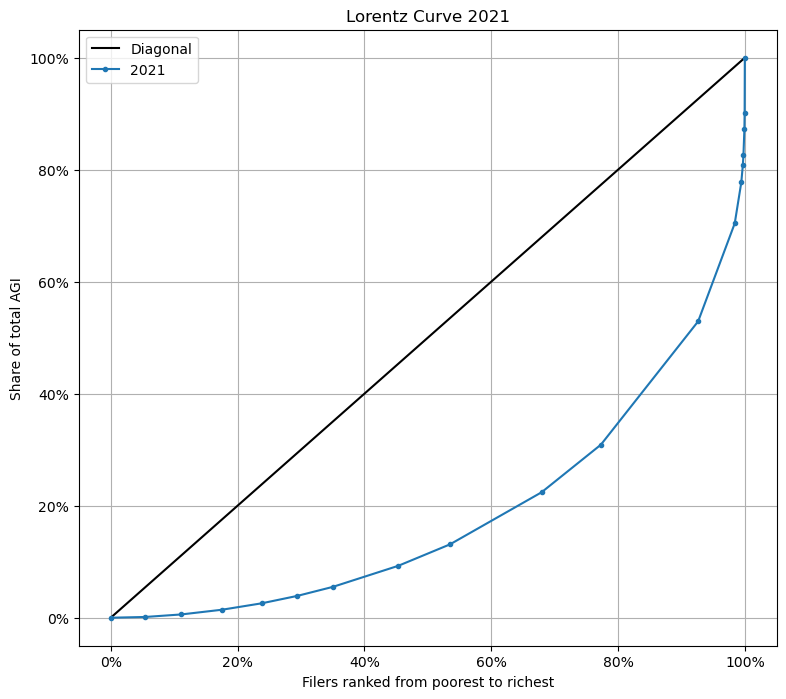

In [5]:
plot_lorentz_curve(data21,save='lorentz_curve1a.png',title='Lorentz Curve 2021',data_label='2021')

In [6]:
# calculating the Gini coefficient
area = (np.trapz(np.linspace(0.0,1.0,len(data21)), np.linspace(0.0,1.0,len(data21))) 
        - np.trapz(data21['Cumsum percentage of total AGI'], data21['Cumsum percentage of total returns']))
gini = area/np.trapz(np.linspace(0.0,1.0,len(data21)), np.linspace(0.0,1.0,len(data21)))

print('Gini coefficient:', gini)

Gini coefficient: 0.627922555865702


## 1.b

Interpolated value for top 10.00% share of total AGI: 0.5086656077832005
Interpolated value for top 1.00% share of total AGI: 0.2540233716155428


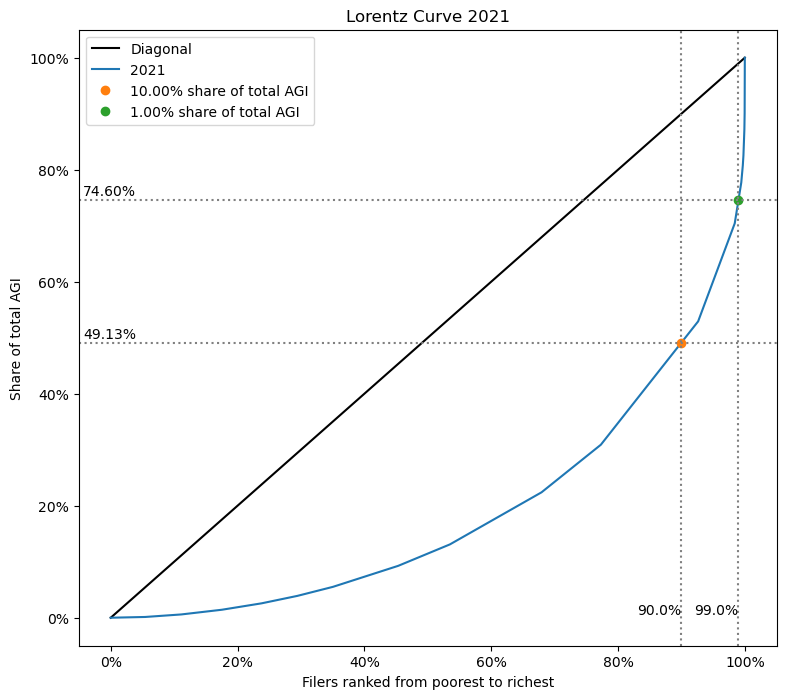

In [7]:
plot_lorentz_curve(data21, [0.90, 0.99],save='lorentz_curve1b.png', title='Lorentz Curve 2021', data_label='2021')

## 1.c

No calculations required

## 1.d

In [8]:
# import of 21in14ar.xls from line 7-27 and only 3 first columns
data_raw93 = pd.read_excel('93in14si.xlsx', header=6, usecols=[0,1,2])

# renaming of columns
data_raw93.columns = ['Size of adjusted gross income', 'Number of returns', 'Adjusted gross income less deficit']

# dropping rows after 20th row no matter the value
data_raw93 = data_raw93.drop(data_raw93.index[16:])

# adjusting data type
data_raw93['Number of returns'] = data_raw93['Number of returns'].astype(int)
data_raw93['Adjusted gross income less deficit'] = data_raw93['Adjusted gross income less deficit'].astype(int)

# printing of data
display(data_raw93)

,Size of adjusted gross income,Number of returns,Adjusted gross income less deficit
0,"All returns, total",114601819,3723339880
1,No adjusted gross income,920431,-52237725
2,"$1 under $5,000",14850154,37291560
3,"$5,000 under $10,000",14727738,110431929
4,"$10,000 under $15,000",13469144,167569389
5,"$15,000 under $20,000",11370849,198121307
6,"$20,000 under $25,000",9474601,212328659
7,"$25,000 under $30,000",7783773,212848223
8,"$30,000 under $40,000",12358341,429243404
9,"$40,000 under $50,000",9072138,405366468


In [9]:
data93 = clean_data(data_raw93, print_head=True)

,Size of adjusted gross income,Number of returns,Adjusted gross income less deficit,Total number of returns,Total adjusted gross income less deficit,Percentage of total returns,Percentage of total AGI,Cumsum percentage of total returns,Cumsum percentage of total AGI
0,0,0,0,113681388,3775577605,0.000000,0.000000,0.000000,0.000000
1,"$1 under $5,000",14850154,37291560,113681388,3775577605,0.130630,0.009877,0.130630,0.009877
2,"$5,000 under $10,000",14727738,110431929,113681388,3775577605,0.129553,0.029249,0.260182,0.039126
3,"$10,000 under $15,000",13469144,167569389,113681388,3775577605,0.118482,0.044382,0.378664,0.083509
4,"$15,000 under $20,000",11370849,198121307,113681388,3775577605,0.100024,0.052474,0.478688,0.135983


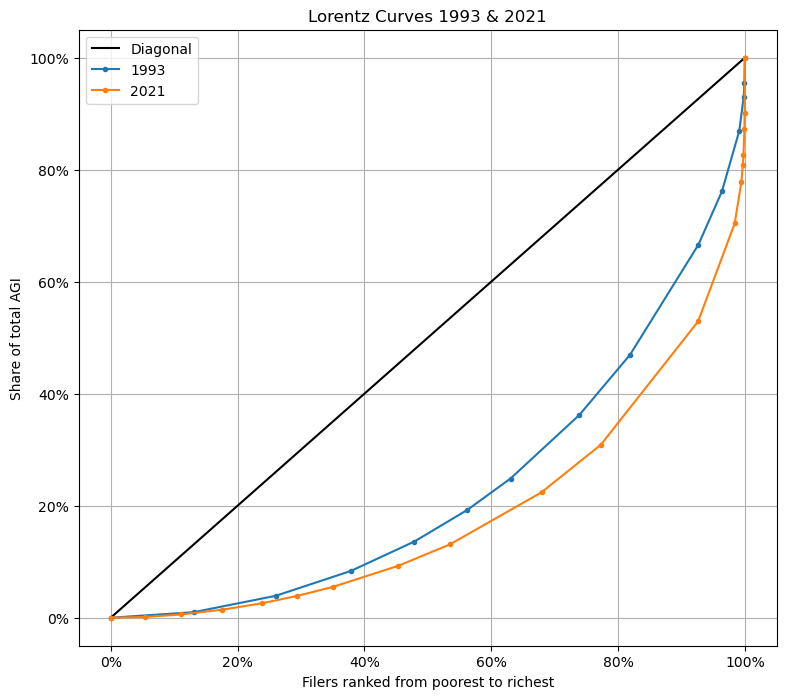

In [10]:
plot_lorentz_curve(data93, data_label='1993', compare=data21, compare_label='2021', title='Lorentz Curves 1993 & 2021', save='lorentz_curve1d.png')

In [11]:
# calculating the Gini coefficient
area93 = (np.trapz(np.linspace(0.0,1.0,len(data93)), np.linspace(0.0,1.0,len(data93))) 
        - np.trapz(data93['Cumsum percentage of total AGI'], data93['Cumsum percentage of total returns']))
gini93 = area93/np.trapz(np.linspace(0.0,1.0,len(data93)), np.linspace(0.0,1.0,len(data93)))

print('Gini coefficient 1993:', gini93)

Gini coefficient 1993: 0.5296265854024349


## 1.e

Interpolated value for top 10.00% share of total AGI: 0.38273362948270595
Interpolated value for top 1.00% share of total AGI: 0.13556562812293982


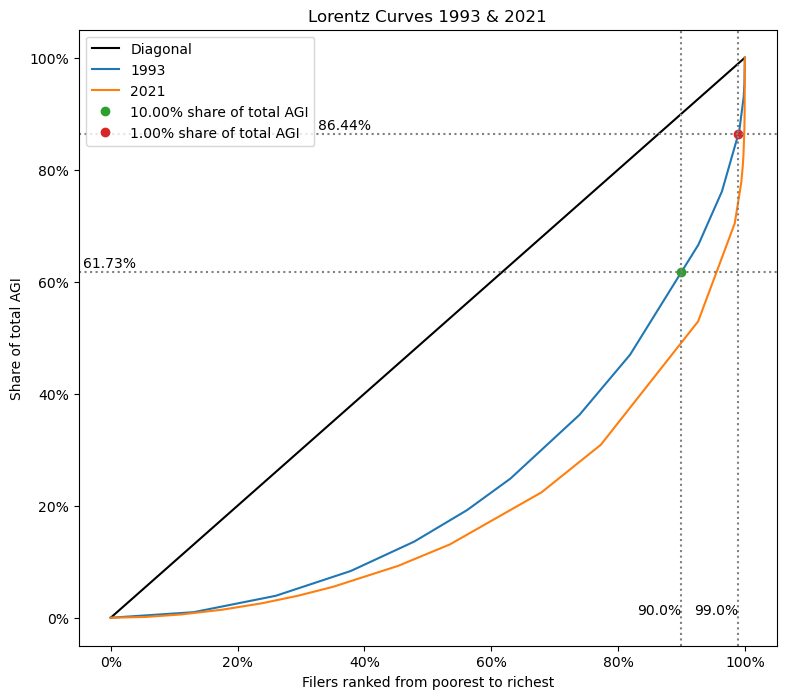

In [12]:
plot_lorentz_curve(data93, [0.90, 0.99], data_label='1993', compare=data21, compare_label='2021', title='Lorentz Curves 1993 & 2021', save='lorentz_curve1e.png')